## Eisenhower Tunnel
The following script examines traffic data at the Eisenhower tunnel on I70 East of Denver is Colorado, USA. 


If you are unfamiliar with the tunnel see the Wiki article here
https://en.wikipedia.org/wiki/Eisenhower_Tunnel


We will load the data for across multiple months and years but this is an example of how the monthly data are presented on the CDOT webpage.

#### Example Data fora  single month
https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2022/3

### Load Primary Packages

In [1]:
#Load pertinent packages

#https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2022/3

import os
import sys
import time
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import defaultdict


import pandas as pd
pd.set_option('display.max_columns', None)


# Import seaborn
import seaborn as sns

### Data Scraping

We will be working with hourly count data collected by CDOT (Colorado Dept of Transport) at numerous stations across Colorado.  We will be examining the station at the Eisehower tunnel. Data are stored with one column per hour and one row per day for each month. As written the script will pull just over 3 years of data.

In [2]:
# specify stations and dates of interest

# url to format: station ID, year, month
url =  "https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/{}/true/{}/{}"


#station '000106' is on the eisenhower tunnel I70
stations = ['000106']


# period of interest
years=['2019','2020','2021','2022']
months= range(1, 13)



### Define web scraping function
define function to pull hourly data for months and years of interest for the Eisenhower station ('000106').

In [3]:
#define function to pull hourly data for months and years of interest
def get_data(url, station_entry, year_entry, month_entry):
     data =[]                    
   
     for station in station_entry:
        for year in year_entry:
            for month in month_entry:
                r2=requests.get(url.format(station,year,month))
                df_list2 = pd.read_html(r2.text, skiprows=0)
                df2=df_list2[0]  #confirmed type is pd.df
                data.append(df2)                             
                
        return data 
        
station=get_data(url,stations,years,months)  



#pd.DataFrame(final)
# Examine first few rows of the data frame.
traffic_pd=pd.concat(station, axis=0)
traffic_pd.head()

# this may take 30 seconds to a  minute.

,Count Date,Dir,0h,1h,2h,3h,4h,5h,6h,7h,8h,9h,10h,11h,12h,13h,14h,15h,16h,17h,18h,19h,20h,21h,22h,23h
0,01/01/2019,P,73,60,69,83,126,202,382,600,1012,1464,2452,2558,2557,2434,2417,2297,1910,1853,1298,1080,767,462,243,151
1,01/01/2019,S,90,81,72,48,63,106,298,1148,1299,1143,1328,1601,1686,1724,1594,1592,1285,916,624,487,416,327,237,147
2,01/02/2019,P,116,93,89,88,224,349,728,942,1117,1467,1749,1718,1749,1791,1832,2038,2049,1653,1146,850,569,359,235,164
3,01/02/2019,S,112,85,71,75,111,258,528,1247,1554,1781,1604,1909,1568,1636,1584,1497,1414,1018,825,648,534,349,237,203
4,01/03/2019,P,104,92,78,88,154,224,459,638,769,1152,1283,1308,1463,1651,1874,2178,2216,1861,1297,846,543,397,216,149


In [4]:
# transform wide data to long

traffic_long = traffic_pd.melt(
    id_vars=['Count Date', 'Dir'],
    var_name='hour', value_name='vehicles_per_hour')


traffic_long['hour']=traffic_long['hour'].replace("h", "",regex=True)
traffic_long['hour']=traffic_long['hour'].astype('int')

#change vehicles to integer
traffic_long['vehicles_per_hour']=traffic_long['vehicles_per_hour'].astype('int')

# Specify input format
traffic_long["Count Date"] =  pd.to_datetime(traffic_long["Count Date"], format="%m/%d/%Y")
#traffic_long["Dir"] =  traffic_long['Dir'].astype("S")

#rename columns
traffic_long=traffic_long.rename(columns={"Count Date": "count_date", "Dir": "direction"})

#sort by date, hour
traffic_long = traffic_long.sort_values(by = ['count_date' ,'hour'])
traffic_long=traffic_long.reindex( )

#print main features
traffic_long.dtypes

#Data dimensions
print( "The extracted data have the following dimensions" +  str(traffic_long.shape))

#print first few rows
traffic_long.head()

The extracted data have the following dimensions(54720, 4)


,count_date,direction,hour,vehicles_per_hour
0,2019-01-01,P,0,73
1,2019-01-01,S,0,90
2280,2019-01-01,P,1,60
2281,2019-01-01,S,1,81
4560,2019-01-01,P,2,69


### Quality check
Examine data for missing values and 5 point summaries

In [5]:


# count missing values in each column
print(traffic_long.isnull().sum())

#Check total counts
traffic_long.count()


count_date           0
direction            0
hour                 0
vehicles_per_hour    0
dtype: int64


count_date           54720
direction            54720
hour                 54720
vehicles_per_hour    54720
dtype: int64

In [6]:
#Check range of values
def min_max(df,col):
    max_value=df[col].max()
    min_value=df[col].min()
    print(min_value,max_value)
    
    
min_max(traffic_long, 'count_date')    
#
min_max(traffic_long, 'vehicles_per_hour')



2019-01-01 00:00:00 2022-03-31 00:00:00
0 3081


### Summary
Examine data for missing values and 5 point summaries

In [7]:
# calculate a 5-number summary of traffic data
from numpy import percentile
from numpy.random import rand
# generate data sample
# calculate quartiles
quartiles = percentile(traffic_long['vehicles_per_hour'], [25, 50, 75])
# calculate min/max
data_min, data_max = traffic_long['vehicles_per_hour'].min(), traffic_long['vehicles_per_hour'].max()
# print 5-number summary
print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)

Min: 0.000
Q1: 169.000
Median: 579.000
Q3: 1125.000
Max: 3081.000


Every day with data has 24 rows (one row per hour in the day) but none of the years are fully complete (365 days). ~5% of each year is missing. We will need to decide to identify and impute these missing points or to proceed without them.  The data appear to be missing at random due to outages at certain stations.  We will need to assess which days are non continuous.

### Add columns to describe date
We will calculate the day of the year, day of the week, specify weekends, and Holidays

In [12]:
# create the hourly traffic data frame
hourly_traffic = traffic_long

# calculate the day of the year for time_series plots
hourly_traffic['day_of_year'] = hourly_traffic['count_date'].dt.dayofyear

#calculate day of week number (0 = Monday, 6= Sunday)
hourly_traffic['day_of_week']=hourly_traffic['count_date'].dt.day_of_week

# designate weekend ()
hourly_traffic.loc[hourly_traffic['day_of_week'] >=5, 'weekend'] = 1 
hourly_traffic.loc[hourly_traffic['day_of_week'] <5, 'weekend'] = 0 


# mark American holidays. Note that holidays that fall on weekedns are applied in the preceding or proceeding week.
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=hourly_traffic['count_date'].min(),
                        end=hourly_traffic['count_date'].max()).to_pydatetime()

#designate which days are holidays
hourly_traffic['holiday'] = hourly_traffic['count_date'].isin(holidays)

#add hours to datetime
hourly_traffic['count_datetime']= hourly_traffic['count_date'] + pd.to_timedelta(hourly_traffic['hour'], unit='h').copy()


#check that tables look good by printing the first few rows.
#hourly_traffic

print(hourly_traffic['day_of_week'].max())
hourly_traffic.head()
#print(hourly_traffic.dtypes)

6


,count_date,direction,hour,vehicles_per_hour,day_of_year,day_of_week,weekend,holiday,count_datetime
0,2019-01-01,P,0,73,1,1,0.0,True,2019-01-01 00:00:00
1,2019-01-01,S,0,90,1,1,0.0,True,2019-01-01 00:00:00
2280,2019-01-01,P,1,60,1,1,0.0,True,2019-01-01 01:00:00
2281,2019-01-01,S,1,81,1,1,0.0,True,2019-01-01 01:00:00
4560,2019-01-01,P,2,69,1,1,0.0,True,2019-01-01 02:00:00


In [14]:
#identify a random date, filter to date of interest, pull the whole week
import datetime as dt
from datetime import timedelta
import random

# select a random date, plot vehicle counts for that day.
min_date= hourly_traffic['count_date'].min()
max_date= hourly_traffic['count_date'].max()


#set seed
random.seed(125)

#get random date between the min and max for the dataset 
time_between_dates = max_date - min_date
days_between_dates = time_between_dates.days
random_number_of_days = random.randrange(days_between_dates)
random_date = min_date + timedelta(days=random_number_of_days)

#random day in the data
random_date

#get day of week, create lower and upper bound for filter to 1 random week
#Monday is 0, Sunday is 6
random_day_of_week=  random_date.day_of_week
day_to_add= 6-random_day_of_week
day_to_sub= 0+random_day_of_week
#
#day_to_add
#day_to_sub


#create lower and upper bound filter
upper_bound= random_date + timedelta(days=day_to_add)
#upper_bound

lower_bound= random_date - timedelta(days=day_to_sub)
#lower_bound

#set mask for date filter
mask = (hourly_traffic['count_date'] >= lower_bound) & (hourly_traffic['count_date'] <= upper_bound)

#filter data to 1 random week
print("The first table is for one week that contains our random day ")
one_week = hourly_traffic.loc[mask]
print(one_week.head())
print(one_week.shape)

#filter data to 1 random day
print("The second tables is for one random day ")
one_day= hourly_traffic.loc[hourly_traffic['count_date'] == random_date]

print(one_day.shape)

print(one_week.dtypes)
one_day.head()

The first table is for one week that contains our random day 
     count_date direction  hour  vehicles_per_hour  day_of_year  day_of_week  \
972  2020-05-11         P     0                 68          132            0   
973  2020-05-11         S     0                 62          132            0   
3252 2020-05-11         P     1                 45          132            0   
3253 2020-05-11         S     1                 42          132            0   
5532 2020-05-11         P     2                 38          132            0   

      weekend  holiday      count_datetime  
972       0.0    False 2020-05-11 00:00:00  
973       0.0    False 2020-05-11 00:00:00  
3252      0.0    False 2020-05-11 01:00:00  
3253      0.0    False 2020-05-11 01:00:00  
5532      0.0    False 2020-05-11 02:00:00  
(336, 9)
The second tables is for one random day 
(48, 9)
count_date           datetime64[ns]
direction                    object
hour                          int32
vehicles_per_hour    

,count_date,direction,hour,vehicles_per_hour,day_of_year,day_of_week,weekend,holiday,count_datetime
974,2020-05-12,P,0,70,133,1,0.0,False,2020-05-12 00:00:00
975,2020-05-12,S,0,68,133,1,0.0,False,2020-05-12 00:00:00
3254,2020-05-12,P,1,34,133,1,0.0,False,2020-05-12 01:00:00
3255,2020-05-12,S,1,69,133,1,0.0,False,2020-05-12 01:00:00
5534,2020-05-12,P,2,50,133,1,0.0,False,2020-05-12 02:00:00


### Create Plots to examine daily and weekly trends

Now that the data are mined and confirmed to be in good order with minimal missingness we want to get  a feel for any cyclicity in the data.  Traffic counts are a product of road usage.  Given the location of the Eisehower tunnel we will geta  good sense of when people are accessing the mountains.  I70 is a busy interstate and through traffic will be a major component of daily use; however, residents of the front range will drive through the tunnel to access mountain recreation.  We should then expect heavy usage during certain seasons, weekends, and holidays.  We will now examine a random day and random week for patterns in the data.  We will include direction to get a feel for when day-trippers may be returning home from the mountains.


This is a  daily plot for a  random day with direction 


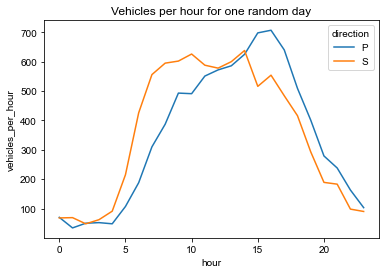

In [15]:
# Daily Plot

print("This is a  daily plot for a  random day with direction ")
sns.lineplot(data=one_day, x="hour", y="vehicles_per_hour", hue="direction").set(
    title="Vehicles per hour for one random day")

sns.set(rc = {'figure.figsize':(25,5)})

In [154]:
# weekly plot random week

#Plot Temperature vs date 
import plotly.express as px


fig = px.line( x = one_week['count_datetime'] ,
              y = one_week['vehicles_per_hour'],
              color=one_week['direction'],
              title = 'Daily Traffic Counts for a Random  Week')
fig.show()

In [ ]:
## The following script segment will add the hours to our sample date to show changes on the x-axis.
#
##add hours to datetime
#import datetime as dt
#one_week['count_datetime']= one_week['count_date'] + pd.to_timedelta(one_week['hour'], unit='h').copy()
#
## wow, that line of code took a lot of Googling.  I hope I dont run out of Google juice. 
#
#
#one_week.head()

The patterns observed in this random week from monday to Sunday are typical.  Traffic directions, indicated as "primary" and "secondary" refer to east and westbound traffic respectively.  Resident on the front Range drive west (secondary, "s") to access the mountains.  Each day westward traffic spike around 8 AM and eastbound traffic peaks in the PM.  There is elevated westward traffic on Friday and a large influx Sunday afternoon.
Next we will generate daily totals for all days in the data set.  We will also identify days that fall on weekedns and holidays.

### Daily Totals

In [19]:
# calculate the daily traffic totals
# Calculate daily sums regardless of direction
daily_traffic = traffic_long.groupby('count_date').sum()
#daily_traffic['day_of_year'] = daily_traffic['count_date'].dt.dayofyear
daily_traffic.reset_index(inplace=True)
daily_traffic = daily_traffic.rename(columns = {'index':'count_date'})

daily_traffic=daily_traffic.rename(columns={"vehicles_per_hour": "vehicles_per_day"})

##calculate day of week number (0 = Monday, 6= Sunday)
daily_traffic['day_of_year'] = daily_traffic['count_date'].dt.dayofyear
daily_traffic['day_of_week']=daily_traffic['count_date'].dt.day_of_week
# designate weekend ()
daily_traffic.loc[daily_traffic['day_of_week'] >=5, 'weekend'] = 1 
daily_traffic.loc[daily_traffic['day_of_week'] <5, 'weekend'] = 0 

#designate which days are holidayss
daily_traffic['holiday'] = daily_traffic['count_date'].isin(holidays)

daily_traffic['year'] = pd.DatetimeIndex(daily_traffic['count_date']).year
#
print(daily_traffic.shape)
daily_traffic.head()




(1140, 8)


,count_date,hour,vehicles_per_day,day_of_year,day_of_week,weekend,holiday,year
0,2019-01-01,552,44862,1,1,0.0,True,2019
1,2019-01-02,552,43963,2,2,0.0,False,2019
2,2019-01-03,552,41906,3,3,0.0,False,2019
3,2019-01-04,552,49802,4,4,0.0,False,2019
4,2019-01-05,552,51967,5,5,1.0,False,2019


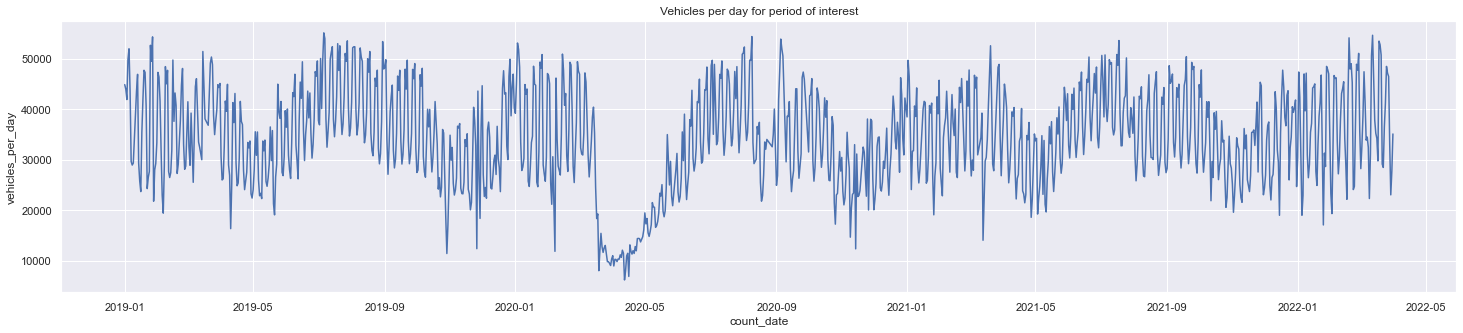

In [20]:
# Plot all time
sns.lineplot(data=daily_traffic, x="count_date", y="vehicles_per_day").set(
    title="Vehicles per day for period of interest")
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(18,8)})
#Plot standardized to day of year

<AxesSubplot:xlabel='day_of_year', ylabel='vehicles_per_day'>

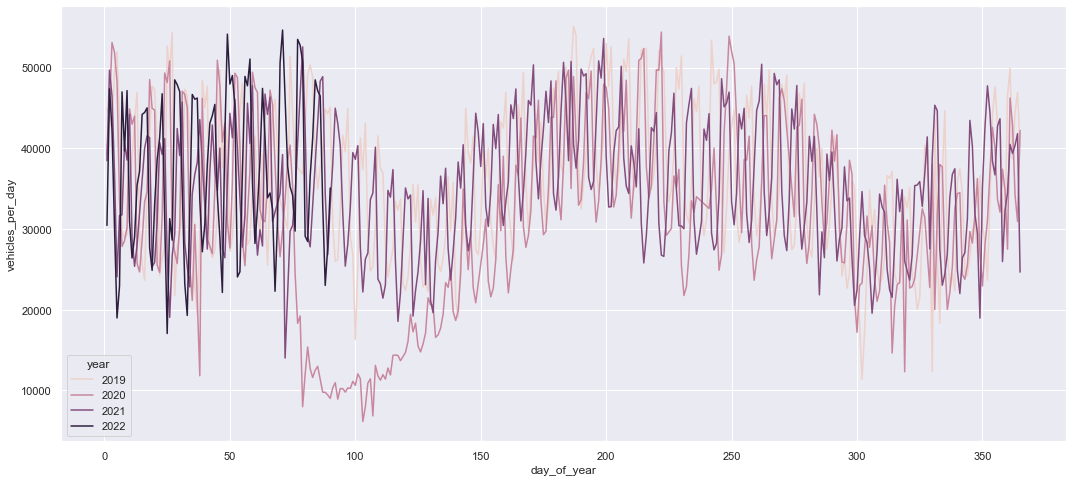

In [21]:
#Plot standardized to day of year Broken out by year
sns.lineplot(data=daily_traffic, x="day_of_year", y="vehicles_per_day", hue="year")



In [22]:
# get value counts for each year.

daily_traffic['year'].value_counts()


2019    357
2021    349
2020    345
2022     89
Name: year, dtype: int64

### Data Quality
None of the years are fully complete (365 days). ~5% of each year is missing (for 2019-2022).  The data appear to be missing at random due to outages at certain stations.  The first step is to identify missing rows and assesshow to handle the missing values.


In [23]:

#get count dates
traffic_qc=   daily_traffic['count_date']

# sort by date, create pandas df
traffic_qc= pd.DataFrame(data=traffic_qc)
traffic_qc=traffic_qc.sort_values(by='count_date')


#calulate difference in date betwwen rows
traffic_qc['day_diff']= traffic_qc['count_date'] - traffic_qc['count_date'].shift(1)

# get count of number of missing days
traffic_qc['day_diff'].value_counts()



1 days    1108
2 days      20
3 days       8
4 days       2
5 days       1
Name: day_diff, dtype: int64

In [24]:
# Filter to values with >1 day

traffic_qc.dtypes
traffic_qc_gaps = traffic_qc[traffic_qc['day_diff'] > pd.Timedelta(1, unit='d')]

#get the first 10 missing values
traffic_qc_gaps.head(10)



,count_date,day_diff
63,2019-03-06,2 days
64,2019-03-08,2 days
66,2019-03-11,2 days
68,2019-03-14,2 days
72,2019-03-20,3 days
73,2019-03-22,2 days
275,2019-10-11,2 days
424,2020-03-09,2 days
474,2020-04-29,2 days
503,2020-05-30,3 days


#### Missing values
Most outages last one day, however, based on the first 10, many 1-day outages can occur in the same week.  This means a whole week of data may be of low quality.  Despite the missing population being an extreme minority we will need to create dummy rows and add interpolated values for daily data. 


### FIGURE OUT THE MISSING ROWS


## Weather Data

Traffic counts and delays are closely related to road conditions. Eisenhower Tunnel is at 11,158' ft elevation and 26 ft (~8 m) annual snowfall. Recent snowfall has the potential to adjust the behavior of drivers; drivers may wait for roads to be cleared or may take the opportunity to ski fresh snow.  The next portion will bring in the weather data, check for nulls, confirm data have the proper data types, and join with the traffic data.  We will be working with hourly weather data sampled to the dates in our current data set.

In [25]:
from datetime import datetime



In [137]:
# Import Meteostat library and dependencies
from datetime import datetime
import meteostat 
from meteostat import Point, Hourly
from meteostat import Stations

# data dictionary can be found here:
#https://dev.meteostat.net/python/hourly.html

# set station coordinates and pull data using "fetch"
stations = Stations()
stations = stations.nearby(39.6787, -105.9194)  # Eisenhower Tunnel
station = stations.fetch(1)


# print station
print("Weather Station name")
print(station.iloc[0, 0:4].transpose())

print("############")

print("station data types")
print(station.dtypes.head(4))

# set date range from HOURLY TRAFFIC
start = hourly_traffic['count_datetime'].min()
end = hourly_traffic['count_datetime'].max()



hourly_weather = Hourly(station, start=start, end=end)
hourly_weather = hourly_weather.normalize()
data_get = data.fetch()

#convert to pandas DF
hourly_weather= pd.DataFrame(data=data_get)
hourly_weather.reset_index(inplace=True)

hourly_weather.head()


Weather Station name
name       Copper Mountain / Slate Creek
country                               US
region                                CO
wmo                                 <NA>
Name: KCCU0, dtype: object
############
station data types
name       object
country    string
region     string
wmo        string
dtype: object


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2019-01-01 01:00:00,-13.0,-18.9,61.0,NaN,NaN,120.0,5.4,NaN,NaN,NaN,NaN
1,2019-01-01 02:00:00,-15.0,-18.9,72.0,NaN,NaN,150.0,11.2,NaN,NaN,NaN,NaN
2,2019-01-01 03:00:00,-15.0,-21.0,60.0,NaN,NaN,160.0,25.9,NaN,NaN,NaN,NaN
3,2019-01-01 04:00:00,-15.0,-21.0,60.0,NaN,NaN,150.0,35.3,NaN,NaN,NaN,NaN
4,2019-01-01 05:00:00,-16.0,-21.1,65.0,NaN,NaN,140.0,29.5,NaN,NaN,NaN,NaN


In [141]:
#Plot Temperature vs date 
import plotly.express as px


fig = px.line( x = hourly_weather['time'] ,
              y = hourly_weather['temp'],
              title = 'Temperature (Celsius) vs. Time')
fig.show()



## Temperature Data Cleanup

Data were pulled from the Copper Mountain Weather Station, closest to Eisenhower Tunnel.  The data are in celsius and metric units.
Temperature data will be checked for missing and data types.

### Missing Values

In [142]:

# get data types
hourly_weather.dtypes

# count missing

percent_missing = hourly_weather.isnull().sum() * 100 / len(hourly_weather)
missing_weather_prcnt = pd.DataFrame({'column_name': hourly_weather.columns,
                                 'percent_missing': percent_missing}).sort_values('percent_missing', ascending=False)

#print percent missing 100 = 100% data are missing
missing_weather_prcnt

,column_name,percent_missing
snow,snow,100.000000
wpgt,wpgt,100.000000
tsun,tsun,100.000000
coco,coco,87.570469
pres,pres,73.797529
prcp,prcp,72.343169
wdir,wdir,22.430131
wspd,wspd,21.839391
dwpt,dwpt,0.053976
rhum,rhum,0.053976


<AxesSubplot:>

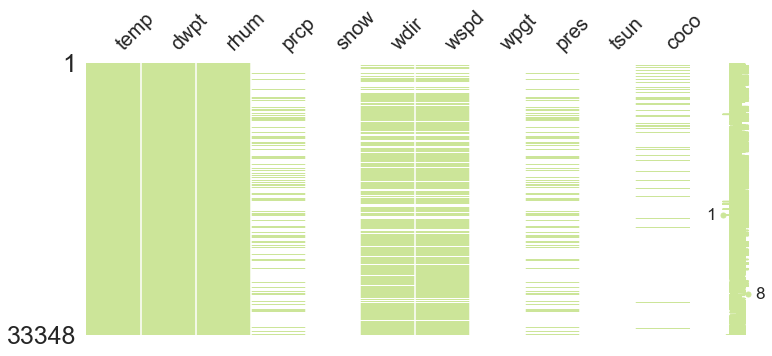

In [120]:
import missingno as msno
%matplotlib inline
msno.matrix(hourly_weather.sort_values('temp'), fontsize=20, figsize=(12,5), color=(0.8, 0.9, .6))

# Values are sorted by temperature

#### Missing findings
The hourly weather data have a high degree of missingness.  Temperature (temp), dewpoint (dwpt), and relative humidity (rhum) can be used with confidence. The rpecipitation field can be used, it will be assumed that missing values record 0 precipitation.

Next steps are to subset the columns, clarify names, and check data types.

In [150]:
#hourly_weather


take_col = ['time', 'temp', 'dwpt', 'rhum', 'prcp']
hourly_weather_sub = pd.DataFrame(hourly_weather, columns=take_col)


#rename columns for clarity

hourly_weather_sub=hourly_weather_sub.rename(columns={"temp": "temp_celsius", "dwpt": "dew_pnt", "rhum": "rel_humidity", "prcp": "prcp_mm"})

# replace NAN in prcp
hourly_weather_sub['prcp_mm'] = hourly_weather_sub['prcp_mm'].fillna(0)

hourly_weather_sub.head()
#hourly_weather_sub.info()

,time,temp_celsius,dew_pnt,rel_humidity,prcp_mm
0,2019-01-01 01:00:00,-13.0,-18.9,61.0,0.0
1,2019-01-01 02:00:00,-15.0,-18.9,72.0,0.0
2,2019-01-01 03:00:00,-15.0,-21.0,60.0,0.0
3,2019-01-01 04:00:00,-15.0,-21.0,60.0,0.0
4,2019-01-01 05:00:00,-16.0,-21.1,65.0,0.0


### Weather Data Replace NA



In [151]:
hourly_weather_sub.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33348 entries, 0 to 33347
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          33348 non-null  datetime64[ns]
 1   temp_celsius  33347 non-null  float64       
 2   dew_pnt       33330 non-null  float64       
 3   rel_humidity  33330 non-null  float64       
 4   prcp_mm       33348 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.3 MB


### Visual Exploration

In [ ]:
#create histogram of vehicles per hour

traffic_long.vehicles_per_hour.plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Vehicles per hour')


In [39]:
# create a visual for the total traffic in a day in time series,  by year

hourly_traffic['count_datetime'].min()


Timestamp('2019-01-01 00:00:00')

In [ ]:
#empty=[]
#url1="https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2021/1"
#r1 = requests.get(url1)
#df_list1 = pd.read_html(r1.text)
#df1 = df_list1[0]
#
#
#url2="https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2020/3"
#r2 = requests.get(url2)
#df_list2 = pd.read_html(r2.text)
#df2=df_list2[0]
#
#df2.head()
#df1.head()